## lesson-5

### Программа с урока:

### Case 1

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [9]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [10]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [11]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

Обучим модель

In [12]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [13]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.16, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [14]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [15]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629


Отрисуем матрицу ошибок

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1832  159]
 [ 195  314]]


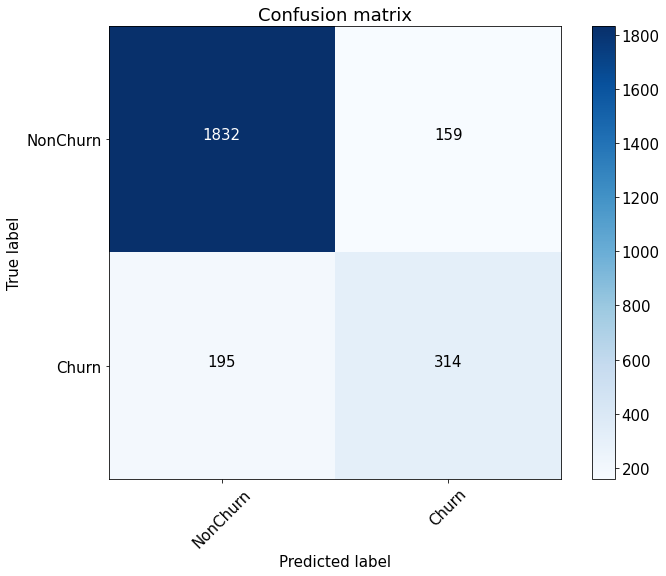

In [17]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, кто ушел в отток на самом деле, но при выбранном нами пороге в 0.38 мы не считаем их таковыми. 

### Пример с перебором параметров с помощью GridSearch

Сетка с параметрами

In [18]:
from sklearn.model_selection import GridSearchCV

params={'classifier__max_features':[0.3, 0.5, 0.7],
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__max_depth':[None]
        }

Запускаем перебор

In [19]:
#grid = GridSearchCV(pipeline,
#                    param_grid=params,
#                    cv=6,
#                    refit=False)

#search = grid.fit(X_train, y_train)
#search.best_params_

Обучаем модель уже сновыми параметрами

In [20]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=None, max_features=0.5, 
                                          min_samples_leaf=3, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [21]:
preds = pipeline.predict_proba(X_test)[:, 1]

In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc = roc_auc_score(y_test, preds)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc_Auc=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix],
                                                                        roc_auc))

Best Threshold=0.389431, F-Score=0.653, Precision=0.661, Recall=0.646, Roc_Auc=0.870


Confusion matrix, without normalization
[[1822  169]
 [ 181  328]]


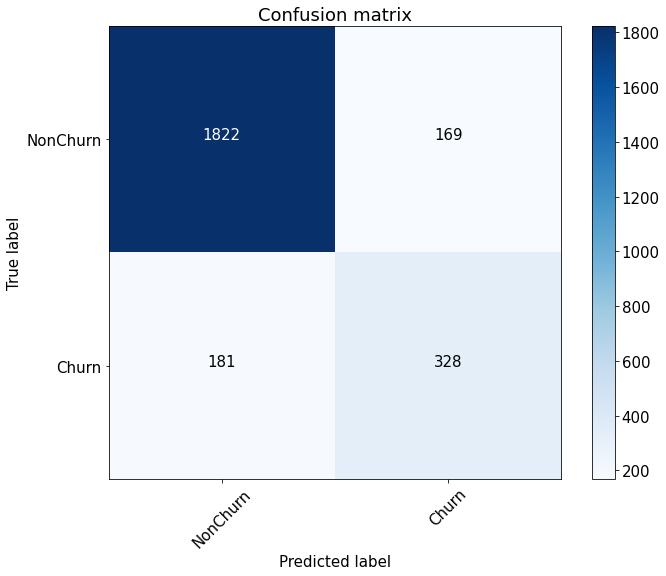

In [23]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Метрики немного стали выше

### 1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standart', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [26]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

#### RandomForestClassifier:

In [27]:
pipeline_rf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [28]:
#обучим наш пайплайн
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [29]:
#наши прогнозы для тестовой выборки
preds_rf = pipeline_rf.predict_proba(X_test)[:, 1]
preds[:10]

array([0.335529  , 0.19039426, 0.08971429, 0.01883333, 0.00166667,
       0.75870854, 0.06538889, 0.07360714, 0.10802381, 0.81744048])

In [30]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_rf)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc_rf = roc_auc_score(y_test, preds_rf)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc_Auc=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix],
                                                                        roc_auc_rf))
thresholds_rf = thresholds[ix]
fscore_rf = fscore[ix]
precision_rf = precision[ix]
recall_rf = recall[ix]

Best Threshold=0.380000, F-Score=0.641, Precision=0.654, Recall=0.629, Roc_Auc=0.864


Confusion matrix, without normalization
[[1833  158]
 [ 195  314]]


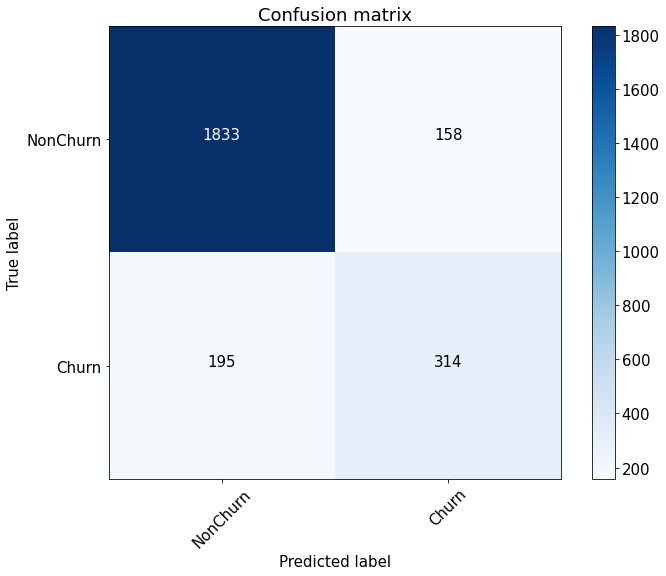

In [31]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_rf = confusion_matrix(y_test, preds_rf>thresholds_rf)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rf, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

#### LogisticRegression:

In [32]:
pipeline_lr = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [33]:
#обучим наш пайплайн
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [34]:
#наши прогнозы для тестовой выборки
preds_lr = pipeline_lr.predict_proba(X_test)[:, 1]
preds[:10]

array([0.335529  , 0.19039426, 0.08971429, 0.01883333, 0.00166667,
       0.75870854, 0.06538889, 0.07360714, 0.10802381, 0.81744048])

In [35]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_lr)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc_lr = roc_auc_score(y_test, preds_lr)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc_Auc=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix],
                                                                        roc_auc_lr))
thresholds_lr = thresholds[ix]
fscore_lr = fscore[ix]
precision_lr = precision[ix]
recall_lr = recall[ix]

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568, Roc_Auc=0.772


Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


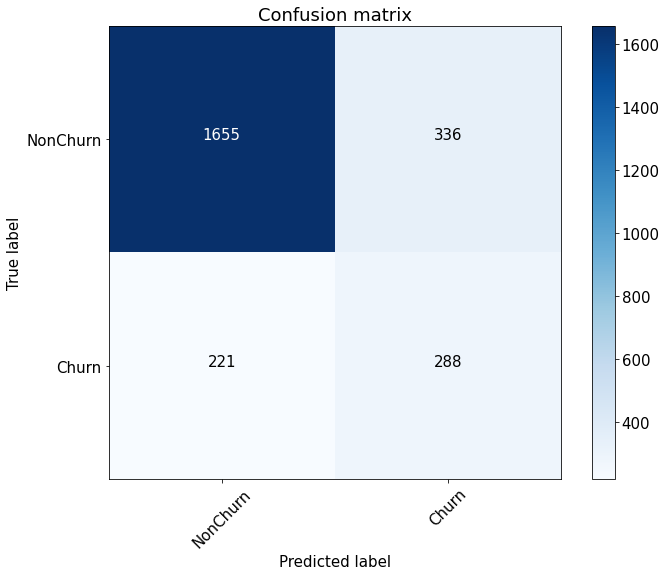

In [36]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_lr = confusion_matrix(y_test, preds_lr>thresholds_lr)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_lr, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

#### GradientBoostingClassifier:

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

In [38]:
pipeline_gb = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

In [39]:
#обучим наш пайплайн
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [40]:
#наши прогнозы для тестовой выборки
preds_gb = pipeline_gb.predict_proba(X_test)[:, 1]
preds[:10]

array([0.335529  , 0.19039426, 0.08971429, 0.01883333, 0.00166667,
       0.75870854, 0.06538889, 0.07360714, 0.10802381, 0.81744048])

In [41]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_gb)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc_gb = roc_auc_score(y_test, preds_gb)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc_Auc=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix],
                                                                        roc_auc_gb))
thresholds_gb = thresholds[ix]
fscore_gb = fscore[ix]
precision_gb = precision[ix]
recall_gb = recall[ix]

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597, Roc_Auc=0.876


Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


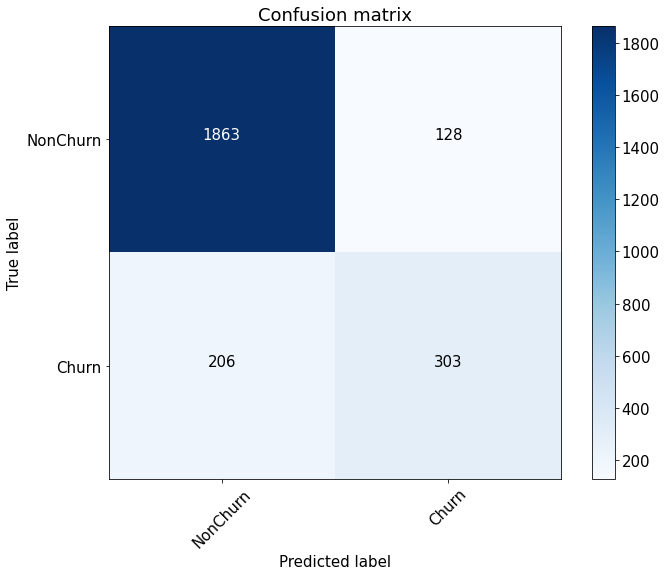

In [42]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gb = confusion_matrix(y_test, preds_gb>thresholds_gb)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_gb, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

In [43]:
united_table = pd.DataFrame({'models': ['RandomForestClassifier', 'LogisticRegression', 'GradientBoostingClassifier'], 
                             'precision': [precision_rf, precision_lr, precision_gb], 
                             'recall': [recall_rf, recall_lr, recall_gb], 
                             'roc_auc': [roc_auc_rf, roc_auc_lr, roc_auc_gb],
                             'f_score': [fscore_rf, fscore_lr, fscore_gb]})
united_table

,models,precision,recall,roc_auc,f_score
0,RandomForestClassifier,0.654397,0.628684,0.863699,0.641283
1,LogisticRegression,0.462400,0.567780,0.772077,0.509700
2,GradientBoostingClassifier,0.703704,0.597250,0.875746,0.646121


#### Вывод:

В наших данных имеется дизбалланс классов 1:4, поэтому мы будем ориентировать на метрику f_score. Так же в будущем мы возможно захотим изменить вес ошибок первого или второго рода. 

По метрике f_score выбираем модель GradientBoostingClassifier.

### 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

True Positive:

In [44]:
TP = cnf_matrix_gb[1,1]
TP

303

False Positive:

In [45]:
FP = cnf_matrix_gb[0,1]
FP

128

Выручка:

In [46]:
TP*2

606

Траты:

In [47]:
(TP + FP)*1

431

Прибыль:

In [48]:
result = TP*2 - (TP + FP)*1
result

175

#### Вывод:

Прибыль данной модели будет 175 долларов.

### 4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

Подбираем гиперпараметры так, чтобы значение (True Positive минус False Positive) было максимальным:

In [49]:
pipeline_gb_best = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42, learning_rate = 0.02, 
                                              max_depth = 3, n_estimators = 1100, subsample = 0.8)),
])

In [50]:
#обучим наш пайплайн
pipeline_gb_best.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [51]:
#наши прогнозы для тестовой выборки
preds_gb_best = pipeline_gb_best.predict_proba(X_test)[:, 1]
preds[:10]

array([0.335529  , 0.19039426, 0.08971429, 0.01883333, 0.00166667,
       0.75870854, 0.06538889, 0.07360714, 0.10802381, 0.81744048])

In [52]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_gb_best)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc_gb_best = roc_auc_score(y_test, preds_gb_best)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc_Auc=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix],
                                                                        roc_auc_gb_best))
thresholds_gb_best = thresholds[ix]
fscore_gb_best = fscore[ix]
precision_gb_best = precision[ix]
recall_gb_best = recall[ix]

Best Threshold=0.445069, F-Score=0.644, Precision=0.712, Recall=0.587, Roc_Auc=0.873


Confusion matrix, without normalization
[[1870  121]
 [ 211  298]]


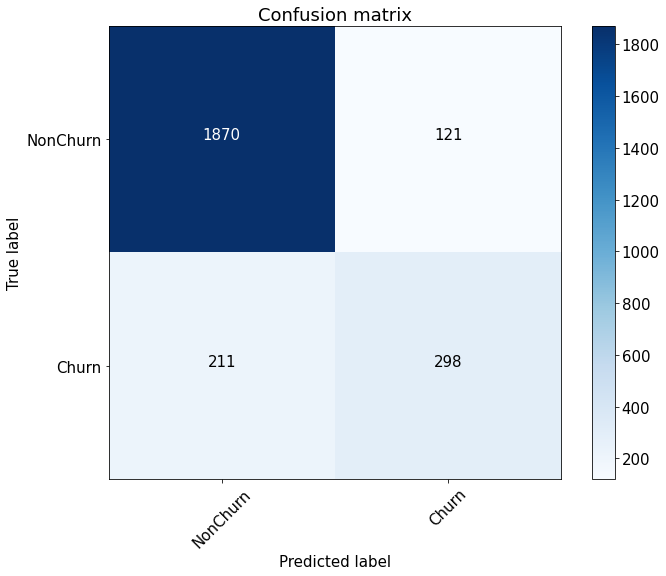

In [53]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gb_best = confusion_matrix(y_test, preds_gb_best>thresholds_gb_best)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_gb_best, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### 5. (опционально) Еще раз провести оценку экономической эффективности

True Positive:

In [54]:
TP = cnf_matrix_gb_best[1,1]
TP

298

False Positive:

In [55]:
FP = cnf_matrix_gb_best[0,1]
FP

121

Выручка:

In [56]:
TP*2

596

Траты:

In [57]:
(TP + FP)*1

419

Прибыль:

In [58]:
result = TP*2 - (TP + FP)*1
result

177

#### Вывод:

Прибыль данной модели будет больше, она равна 177 долларов.